## $\text{Импортируем все необходимые библиотеки}$

In [1]:
!pip install catboost

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 99.2/99.2 MB 5.4 MB/s eta 0:00:00


In [2]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [18]:
import re
import math
import torch
import random
import shutil
import collections
import numpy as np
import pandas as pd
import torch.nn as nn
import seaborn as sns
import matplotlib.pyplot as plt
from tqdm import tqdm
from PIL import Image
from catboost import CatBoostClassifier
from transformers import AutoTokenizer
from sklearn.metrics import roc_auc_score, accuracy_score, f1_score, precision_score, recall_score, confusion_matrix
from torchvision import transforms
from torchvision.models import resnext101_32x8d
from torch.nn.utils import clip_grad_norm_
from torch.optim import AdamW, lr_scheduler
from torchvision.datasets import ImageFolder
from torch.utils.data import Dataset, DataLoader, random_split
from sklearn.model_selection import train_test_split

In [4]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

device(type='cpu')

## $\text{Займемся формированием датасета для обучения нашей модели}$

In [5]:
transform = transforms.Compose([
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                         std=[0.229, 0.224, 0.225])
])

data = ImageFolder("/content/drive/MyDrive/data", transform=transform)

In [6]:
train_size = int(0.8*len(data))
test_size= len(data) - train_size

train_data, test_data = random_split(data, [train_size, test_size])

In [7]:
batch_size = 8

train_loader = DataLoader(train_data, 8, shuffle=True)
test_loader = DataLoader(test_data, 8)

In [8]:
model = resnext101_32x8d(weights='ResNeXt101_32X8D_Weights.IMAGENET1K_V2')

Downloading: "https://download.pytorch.org/models/resnext101_32x8d-110c445d.pth" to /root/.cache/torch/hub/checkpoints/resnext101_32x8d-110c445d.pth
100%|██████████| 340M/340M [00:06<00:00, 53.8MB/s]


### $\text{Поскольку мы будем использовать предтренированную модель, то нам} $
### $\text{нужно убрать последний слой, потому что он нужен для классификации на датасете ImageNet}$

In [9]:
model = nn.Sequential(*list(model.children())[:-1]).to(device) # убираем последний слой

### $\text{Далее применим следующую идею:}$
### $\text{Будем прогонять наши изображения через предтренированную модель, после чего полученные эмбэддинги будем подавать}$
### $\text{в градиентный бустинг, и вот уже его будем обучать на классификацию}$

In [ ]:
train_embeddings = []
train_labels = []

test_embeddings = []
test_labels = []

model.eval()

with torch.no_grad():
    for images, labels in tqdm(train_loader):
        out = model(images.to(device))
        # print(out)
        # print(f"out.shape: {out.shape}")
        # print(f"out_reshape: {out.view(out.size(0), -1)}")

        train_embeddings.append(out.view(out.size(0), -1).cpu().numpy())
        train_labels.append(labels.cpu().numpy())

100%|██████████| 60/60 [01:59<00:00,  1.99s/it]


In [ ]:
with torch.no_grad():
    for images, labels in tqdm(test_loader):
        out = model(images.to(device))
        # print(out)
        # print(f"out.shape: {out.shape}")
        # print(f"out_reshape: {out.view(out.size(0), -1)}")

        test_embeddings.append(out.view(out.size(0), -1).cpu().numpy())
        test_labels.append(labels.cpu().numpy())

100%|██████████| 15/15 [00:31<00:00,  2.09s/it]


### $\text{Создадим выборки для того, чтобы их можно было подавать в градиентный бустинг}$

In [ ]:
X_train = np.concatenate(train_embeddings, axis=0)
y_train = np.concatenate(train_labels, axis=0)

X_test = np.concatenate(test_embeddings, axis=0)
y_test = np.concatenate(test_labels, axis=0)

In [ ]:
np.save('/content/drive/MyDrive/train_embeddings.npy', X_train.astype(np.float32))
np.save('/content/drive/MyDrive/train_labels.npy', y_train)

In [ ]:
np.save('/content/drive/MyDrive/test_embeddings.npy', X_test.astype(np.float32))
np.save('/content/drive/MyDrive/test_labels.npy', y_test)

### $\text{Далее обучим градиентный бустинг на классификацию наличия ж/д на фотографиях}$

In [10]:
X_train = np.load('/content/drive/MyDrive/train_embeddings.npy')
y_train = np.load('/content/drive/MyDrive/train_labels.npy')

In [11]:
X_test = np.load('/content/drive/MyDrive/test_embeddings.npy')
y_test = np.load('/content/drive/MyDrive/test_labels.npy')

In [12]:
classifier = CatBoostClassifier(verbose=0)

In [13]:
classifier.fit(X_train, y_train)

### $\text{Далее проведем инференс нашей модели, посмотрим и оценим основные метрики классфикации и сделаем выводы}$

In [14]:
outputs = classifier.predict(X_test)

### $\small \text{Accuracy score:}$
### $$\small \text{Accuracy} = \frac{TP + TN}{TP + TN + FP + FN}$$

In [15]:
accuracy = accuracy_score(y_test, outputs)
print(f"Accuracy = {accuracy}")

Accuracy = 0.8


### $\small \text{F1-score, precision и recall}$
### $\text{Для этого познакомимся со следующими понятиями:}$

$$
\begin{aligned}
\large \text{TP} &= \text{True Positive} \quad \Large \text{(правильно определили, что есть ЖД)} \\
\large \text{FP} &= \text{False Positive} \quad \Large \text{(ошибочно предсказали ЖД)} \\
\large \text{FN} &= \text{False Negative} \quad \Large \text{(пропустили ЖД)}
\end{aligned}
$$

### $\text{Формулы:}$
### $$\small \text{Precision} = \frac{TP}{TP + FP}$$
### $$\small \text{Recall} = \frac{TP}{TP + FN}$$
### $$\small \text{F}_{1} = \frac{2}{\frac{1}{Precision}+\frac{1}{Recall}}$$

In [16]:
precision = precision_score(y_test, outputs)
recall = recall_score(y_test, outputs)
f1 = f1_score(y_test, outputs)

print(f"precision = {precision}")
print(f"recall = {recall}")
print(f"f1 = {f1}")

precision = 0.7741935483870968
recall = 0.8275862068965517
f1 = 0.8


### $\text{Также в задачах классификации удобно пользоваться так называемой матрицей ошибок } \small \text{Confusion Matrix}$
### $\text{Матрица представляет собой 2 столбца и 2 колонки, по которым считаются все основные метрики}$

In [ ]:
conf_matr = confusion_matrix(y_test, outputs)

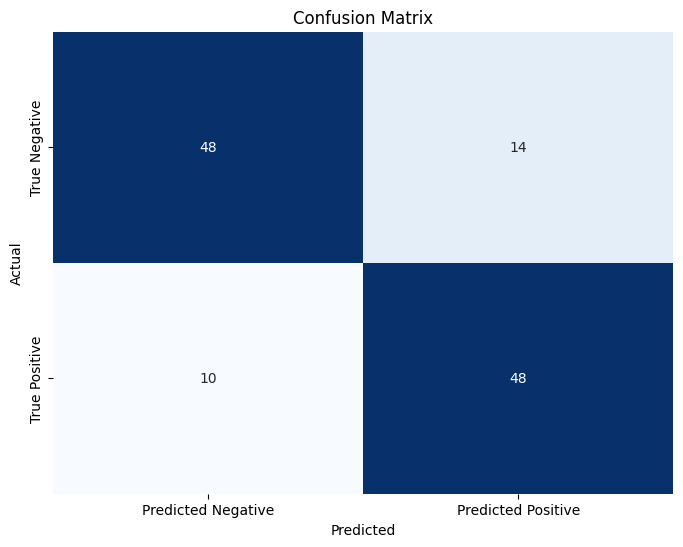

In [ ]:
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matr, annot=True, fmt='d', cmap='Blues', cbar=False,
            xticklabels=['Predicted Negative', 'Predicted Positive'],
            yticklabels=['True Negative', 'True Positive'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

### $\text{Прогоним через нашу модель несколько фотографий}$

In [63]:
rw_img_1 = Image.open("/content/drive/MyDrive/test_images/жд1.jpg")
rw_img_2 = Image.open("/content/drive/MyDrive/test_images/жд2.jpg")

no_rw_img_1 = Image.open("/content/drive/MyDrive/test_images/нежд1.jpg")
no_rw_img_2 = Image.open("/content/drive/MyDrive/test_images/нежд2.jpg")

In [67]:
images = [rw_img_1, rw_img_2, no_rw_img_1, no_rw_img_2]

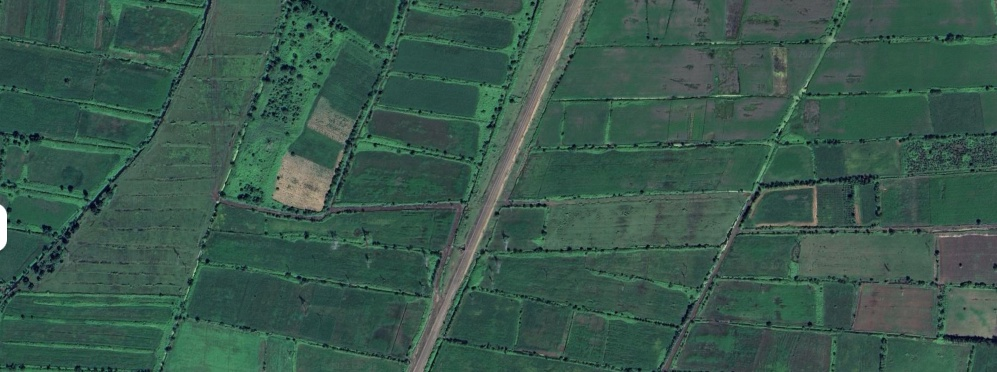

In [24]:
rw_img_1

### $\text{Обработаем картинки для подачи в нашу модель}$

In [28]:
rw_img_1 = transform(rw_img_1)
rw_img_2 = transform(rw_img_2)
no_rw_img_1 = transform(no_rw_img_1)
no_rw_img_2 = transform(no_rw_img_2)

In [58]:
list_of_images = [rw_img_1, rw_img_2, no_rw_img_1, no_rw_img_2]
labels = [1, 1, 0, 0]
predictions = []

In [59]:
rw_img_1.unsqueeze(0).shape

torch.Size([1, 3, 224, 224])

In [60]:
with torch.no_grad():
    for image in list_of_images:
        out_from_nn = model(image.unsqueeze(0))
        out_from_nn = out_from_nn.view(out_from_nn.size(0), -1).squeeze(0).cpu().numpy()
        out = classifier.predict(out_from_nn)
        predictions.append(out)

In [62]:
test_accur = accuracy_score(labels, predictions)
print(test_accur)

0.75


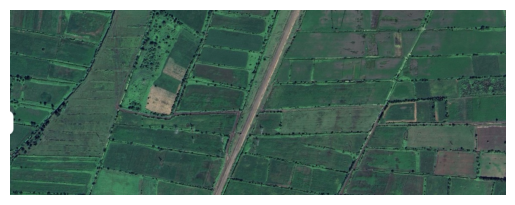

⛔ Железная дорога не обнаружена
Истинная метка: железная дорога есть


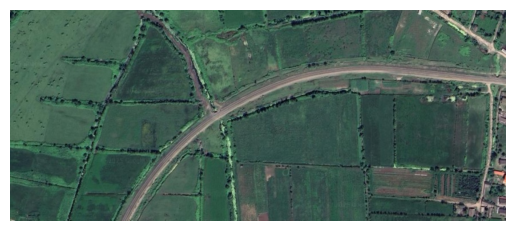

🚂 Обнаружена железная дорога
Истинная метка: железная дорога есть


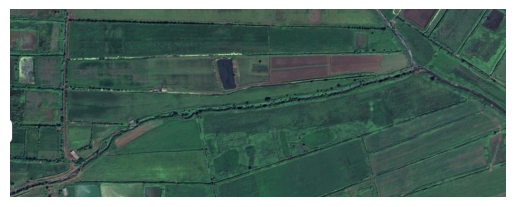

⛔ Железная дорога не обнаружена
Истинная метка: железной дороги нет


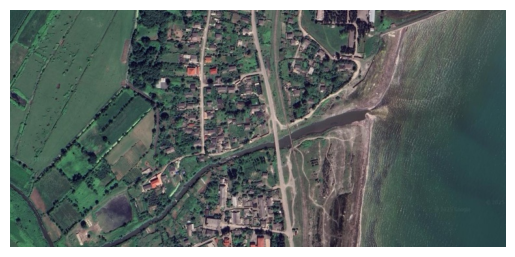

⛔ Железная дорога не обнаружена
Истинная метка: железной дороги нет


In [78]:
for i in range(len(list_of_images)):
    plt.imshow(images[i])
    plt.axis('off')
    plt.show()
    if predictions[i] == 1:
        print("🚂 Обнаружена железная дорога")
        if labels[i] == 1:
            print(f"Истинная метка: железная дорога есть")
        else:
            print(f"Истинная метка: железной дороги нет")
    else:
        print("⛔ Железная дорога не обнаружена")
        if labels[i] == 1:
            print(f"Истинная метка: железная дорога есть")
        else:
            print(f"Истинная метка: железной дороги нет")